<a href="https://colab.research.google.com/github/AAA123404/Financial-big-data-analysis/blob/main/week9%E4%BD%9C%E6%A5%AD_%E6%99%82%E9%96%93%E5%BA%8F%E5%88%97_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
!pip install yfinance pandas numpy torch scikit-learn matplotlib

In [74]:
import numpy as np
import pandas as pd
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import torch.optim as optim

In [75]:
tsmc = yf.download('2330.TW', start='2020-01-01')
tsmc

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW
Date,,,,,,
2020-01-02 00:00:00+00:00,306.430084,339.0,339.0,332.5,332.5,31754120
2020-01-03 00:00:00+00:00,306.882141,339.5,345.0,335.5,344.0,41811268
2020-01-06 00:00:00+00:00,300.102661,332.0,334.5,332.0,333.0,45343057
2020-01-07 00:00:00+00:00,297.842865,329.5,333.0,326.5,332.5,50879181
2020-01-08 00:00:00+00:00,297.842865,329.5,333.0,325.0,325.0,37567748
...,...,...,...,...,...,...
2024-11-04 00:00:00+00:00,1040.000000,1040.0,1045.0,1025.0,1030.0,26747978
2024-11-05 00:00:00+00:00,1050.000000,1050.0,1055.0,1030.0,1030.0,32385622


In [76]:
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def calculate_macd(df, fast_period=12, slow_period=26):
    df['EMA12'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA26'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    return df[['MACD']]


def create_features(df):
  df_feat = df.copy()
  df_feat['MA5'] = df_feat['Close'].rolling(window=5).mean()
  df_feat['MA20'] = df_feat['Close'].rolling(window=20).mean()
  df_feat['RSI'] = calculate_rsi(df_feat['Close'])
  df_feat['MACD'] = calculate_macd(df_feat)['MACD']
  df_feat = df_feat.dropna()
  return df_feat

df_features = create_features(tsmc)
df_features

Price,Adj Close,Close,High,Low,Open,Volume,MA5,MA20,RSI,EMA12,EMA26,MACD
Ticker,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,2330.TW,,,,,,
Date,,,,,,,,,,,,
2020-02-07 00:00:00+00:00,296.487030,328.0,330.5,326.0,330.0,28798327,325.6,331.950,43.065693,328.735034,331.952663,-3.217629
2020-02-10 00:00:00+00:00,296.035004,327.5,328.0,321.0,321.5,30632424,328.1,331.375,41.044776,328.545029,331.622836,-3.077807
2020-02-11 00:00:00+00:00,299.650696,331.5,332.5,330.0,330.5,27524935,329.4,330.975,42.753623,328.999640,331.613737,-2.614097
2020-02-12 00:00:00+00:00,302.814484,335.0,336.0,333.0,333.5,37612639,330.9,331.125,41.911765,329.922772,331.864571,-1.941799
2020-02-13 00:00:00+00:00,302.814484,335.0,338.0,335.0,338.0,22757021,331.4,331.400,45.967742,330.703884,332.096825,-1.392941
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04 00:00:00+00:00,1040.000000,1040.0,1045.0,1025.0,1030.0,26747978,1033.0,1046.000,41.176471,1040.975696,1027.651991,13.323705
2024-11-05 00:00:00+00:00,1050.000000,1050.0,1055.0,1030.0,1030.0,32385622,1035.0,1048.250,51.612903,1042.364050,1029.307399,13.056651


In [77]:
feature_columns = ['MA5', 'MA20', 'RSI', 'MACD','Open', 'High', 'Low', 'Close']
X = df_features[feature_columns].values
y = df_features['Close'].shift(-1).values[:-1]
X = X[:-1]

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(X_scaled) * 0.8)

X_train = X_scaled[:train_size]
X_test = X_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

def create_sequences(X, y, sequence_length=20):
    sequences_X, sequences_y = [], []
    for i in range(len(X) - sequence_length):
        sequences_X.append(X[i:i+sequence_length])
        sequences_y.append(y[i + sequence_length])
    return np.array(sequences_X), np.array(sequences_y)

X_train_seq, y_train_seq = create_sequences(X_train, y_train)
X_test_seq, y_test_seq = create_sequences(X_test, y_test)


X_train_seq = torch.FloatTensor(X_train_seq)
y_train_seq = torch.FloatTensor(y_train_seq)
X_test_seq = torch.FloatTensor(X_test_seq)
y_test_seq = torch.FloatTensor(y_test_seq)


In [78]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = StockDataset(X_train, y_train)
test_dataset = StockDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(StockLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        lstm_out, (hn, cn) = self.lstm(x)
        lstm_out_last = lstm_out[:, -1, :]
        lstm_out_last = self.dropout(lstm_out_last)
        output = self.fc(lstm_out_last)

        return output

In [80]:
input_size = len(feature_columns)
hidden_size = 64
num_layers = 2
output_size = 1

model = StockLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, output_size=output_size)
outputs = model(X_train_seq)

In [81]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [82]:
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  #
    outputs = model(X_train_seq)
    loss = criterion(outputs, y_train_seq)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0086
Epoch [20/100], Loss: 0.0084
Epoch [30/100], Loss: 0.0076
Epoch [40/100], Loss: 0.0058
Epoch [50/100], Loss: 0.0034
Epoch [60/100], Loss: 0.0018
Epoch [70/100], Loss: 0.0017
Epoch [80/100], Loss: 0.0014
Epoch [90/100], Loss: 0.0012
Epoch [100/100], Loss: 0.0012


In [85]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test_seq)


y_pred = scaler_y.inverse_transform(y_pred.detach().numpy().reshape(-1,1))
y_test = scaler_y.inverse_transform(y_test_seq.numpy().reshape(-1,1))

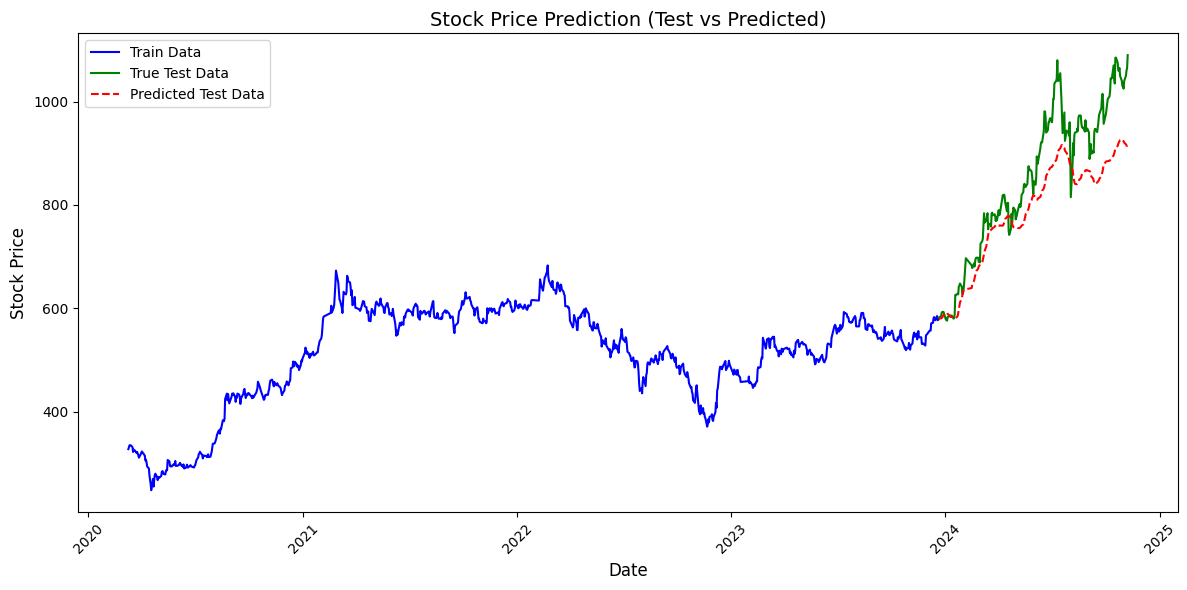

In [86]:
train_dates = df_features.index[20:train_size+20]
test_dates = df_features.index[train_size+20:-1]


plt.figure(figsize=(12, 6))
plt.plot(train_dates, scaler_y.inverse_transform(y_train), label='Train Data', color='blue')
plt.plot(test_dates, y_test, label='True Test Data', color='green')
plt.plot(test_dates, y_pred, label='Predicted Test Data', color='red', linestyle='--')


plt.title('Stock Price Prediction (Test vs Predicted)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend()


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
